<font color = blue> First of all, we have to import some libraries: </font>


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import zipfile
import re
from scipy import stats
from sklearn.preprocessing import RobustScaler
from catboost import CatBoostRegressor
from tqdm import tqdm
import gc
import datetime as dt

<font color = blue> Data loading and merging to get the 'logerror' which is our target: </font>

In [2]:
prop = pd.read_csv('./data/properties_2016.csv')
train = pd.read_csv('./data/train_2016_v2.csv')
data = pd.merge(train, prop, on='parcelid', how='left')
data.head()

/Users/emachado/miniconda3/envs/ironhack/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [3]:
data.shape


(90275, 60)

In [4]:
data['transactiondate'] = [''.join(x.split('-')[0:2]) for x in data['transactiondate']]
data['transactiondate'].value_counts()

201606    10922
201608    10476
201605     9961
201607     9947
201609     9575
201604     9311
201603     8652
201601     6556
201602     6333
201610     4977
201611     1826
201612     1739
Name: transactiondate, dtype: int64

In [5]:
data.columns

Index(['parcelid', 'logerror', 'transactiondate', 'airconditioningtypeid',
       'architecturalstyletypeid', 'basementsqft', 'bathroomcnt', 'bedroomcnt',
       'buildingclasstypeid', 'buildingqualitytypeid', 'calculatedbathnbr',
       'decktypeid', 'finishedfloor1squarefeet',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
       'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50',
       'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcn

In [6]:
data['propertylandusetypeid'].value_counts()


261.0    60637
266.0    22815
246.0     2376
269.0     2334
248.0      879
247.0      629
265.0      356
263.0       84
260.0       62
275.0       46
267.0       28
31.0        17
264.0       11
47.0         1
Name: propertylandusetypeid, dtype: int64

In [7]:
data['heatingorsystemtypeid'].value_counts()

2.0     38303
7.0     15519
24.0     1071
6.0       970
20.0       97
13.0       76
18.0       25
1.0        13
14.0        2
10.0        2
11.0        1
12.0        1
Name: heatingorsystemtypeid, dtype: int64

In [8]:
data['typeconstructiontypeid'].value_counts()

6.0     296
4.0       2
13.0      1
Name: typeconstructiontypeid, dtype: int64

In [9]:
data['airconditioningtypeid'].value_counts()

1.0     26668
13.0     1833
5.0       215
11.0       63
9.0         1
3.0         1
Name: airconditioningtypeid, dtype: int64

In [10]:
data['buildingclasstypeid'].value_counts()

4.0    16
Name: buildingclasstypeid, dtype: int64

In [11]:
data['regionidcity'].unique()

array([ 12447.,  32380.,  47019.,  17686.,  29712.,  24174.,  13150.,
        25459.,  46098., 396054.,  52650.,  17150.,  25218.,  53655.,
        46298.,  34780.,  47568.,  24832.,   5465.,  40227.,  54311.,
        10389.,  21412.,   6395.,  33252.,  25458.,  24384.,  20008.,
        33836.,   8384.,  24812.,  53571.,  51617.,  45888.,  45457.,
        15554.,  24245.,  16764.,  27110.,  40081.,  41673.,  34278.,
        12773.,  16389.,  42150.,  54970.,     nan,  52842.,  34543.,
        15237.,  53636.,  37688.,  13693.,   5534.,  54722.,  50749.,
        51239.,  27491., 118225.,  27103.,  13091.,  33837.,  50677.,
        10608.,  10723.,  48424.,  47762.,   6021.,   9840.,  18874.,
        38032.,  44833.,  24435.,  12292.,  10774.,  37015., 396556.,
        45602.,  33311.,  33612.,  44116.,  10241.,  25974.,  21778.,
        14634.,  11626.,  40009.,  14542.,  30187.,  32923.,  26483.,
        26531.,  14906.,  14111.,  26964.,  18875.,  30908.,  13716.,
        39306., 1189

In [12]:
data['regionidcounty'].unique()

array([3101., 1286., 2061.])

In [13]:
data['regionidneighborhood'].unique()

array([ 31817.,     nan, 275411.,  54300.,  51906.,  19810., 273096.,
       274961.,  47950., 276476.,   7877., 273567.,  37739., 416320.,
       274359.,  40215.,  40548., 268509., 275738., 275426., 118208.,
        48570., 114914., 762187., 275396., 113455., 268134., 403197.,
        47880.,  13327., 273252., 274800., 276606., 268473., 276450.,
        46736., 274828.,  28119.,  27080., 113749., 116302., 274895.,
        13017., 276157., 268496.,  27328.,  27484., 403142., 275470.,
       275695., 274750., 268548., 118849., 118872., 417224., 273197.,
       268249.,  46795., 403196., 268002., 116375.,  21056., 113910.,
       276119.,  48200., 113688., 274049., 115609., 275496., 114246.,
        32368., 275994.,   6952., 113886., 403192., 116774., 275405.,
       268097.,  41466., 118825.,  37835., 275884., 272968., 273539.,
       416304.,  34213.,  41131., 275958., 268588.,  32059., 117954.,
       274684., 274513., 274514., 275111., 762685., 403184.,  33183.,
       276256., 2758

In [14]:
data['regionidzip'].unique()

array([ 96370.,  96962.,  96293.,  96222.,  96961.,  96109.,  96091.,
        97101.,  96987.,  96963.,  96426.,  96120.,  96437.,  96947.,
        97035.,  96964.,  96393.,  96238.,  96990.,  96379.,  96239.,
        97001.,  97052.,  96026.,  97050.,  96190.,  97329.,  96349.,
        96374.,  96088.,  96242.,  96008.,  96361.,  96364.,  97007.,
        97078.,  96220.,  97004.,  96295.,  97067.,  96043.,  97048.,
        96387.,  96971.,  96013.,  96505.,  96506.,  96513.,  97008.,
        97041.,  96978.,  96097.,  96133.,  96324.,  96993.,  96474.,
        97026.,  96007.,  96952.,  97116.,  96447.,  96436.,  97005.,
        96384.,  96475.,  96383.,  96996.,  96986.,  96072.,  96107.,
        96965.,  97020.,  96247.,  97106.,  96995.,  97059.,  96169.,
        96028.,  96020.,  96969.,  96029.,  96351.,  96974.,  97083.,
        96183.,  96957.,  97107.,  96420.,  96193.,  96058.,  97065.,
        97039.,  96337.,  96982.,  96507.,  97319.,  96159.,  96369.,
        96240.,  959

In [15]:
data['regionidzip'].isnull().sum()

35

In [16]:
data['buildingqualitytypeid'].unique()

array([ 4., nan,  1.,  7., 12., 10.,  8.,  6., 11.])

In [17]:
data['pooltypeid10'].value_counts()


1.0    1161
Name: pooltypeid10, dtype: int64

In [18]:
data['hashottuborspa'].replace(True,1.0)

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
6        NaN
7        NaN
8        NaN
9        NaN
10       NaN
11       NaN
12       NaN
13       NaN
14       NaN
15       NaN
16       NaN
17       NaN
18       NaN
19       NaN
20       NaN
21       NaN
22       NaN
23       1.0
24       NaN
25       NaN
26       NaN
27       NaN
28       NaN
29       NaN
        ... 
90245    NaN
90246    NaN
90247    NaN
90248    NaN
90249    NaN
90250    NaN
90251    NaN
90252    NaN
90253    NaN
90254    NaN
90255    NaN
90256    NaN
90257    NaN
90258    NaN
90259    NaN
90260    NaN
90261    NaN
90262    NaN
90263    NaN
90264    NaN
90265    NaN
90266    NaN
90267    NaN
90268    NaN
90269    NaN
90270    NaN
90271    NaN
90272    NaN
90273    NaN
90274    NaN
Name: hashottuborspa, Length: 90275, dtype: float64

In [19]:
data['hashottuborspa'].value_counts()

True    2365
Name: hashottuborspa, dtype: int64

In [20]:
data['bathroomcnt'].value_counts()


2.0     36534
3.0     19946
1.0     15035
2.5      8091
4.0      3743
1.5      1641
0.0      1165
5.0      1142
3.5      1091
4.5       795
6.0       448
5.5       253
7.0       155
8.0       114
6.5        54
9.0        36
10.0       14
7.5         9
11.0        3
12.0        3
8.5         1
20.0        1
15.0        1
Name: bathroomcnt, dtype: int64

In [21]:
data['calculatedbathnbr'].value_counts()

2.0     36534
3.0     19946
1.0     15035
2.5      8084
4.0      3743
1.5      1636
5.0      1142
3.5      1088
4.5       793
6.0       448
5.5       253
7.0       155
8.0       114
6.5        54
9.0        36
10.0       14
7.5         9
11.0        3
12.0        3
8.5         1
20.0        1
15.0        1
Name: calculatedbathnbr, dtype: int64

In [22]:
data['bath_count'] = data[['bathroomcnt', 'calculatedbathnbr']].max(axis=1)
data['bath_count'].value_counts()

2.0     36534
3.0     19946
1.0     15035
2.5      8091
4.0      3743
1.5      1641
0.0      1165
5.0      1142
3.5      1091
4.5       795
6.0       448
5.5       253
7.0       155
8.0       114
6.5        54
9.0        36
10.0       14
7.5         9
11.0        3
12.0        3
8.5         1
20.0        1
15.0        1
Name: bath_count, dtype: int64

In [23]:
data['hot_tub_spa'] = data['hashottuborspa'] + data['pooltypeid10'].map(bool)
data['hot_tub_spa'].value_counts()
data['hot_tub_spa'].replace(2,1)

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
6        NaN
7        NaN
8        NaN
9        NaN
10       NaN
11       NaN
12       NaN
13       NaN
14       NaN
15       NaN
16       NaN
17       NaN
18       NaN
19       NaN
20       NaN
21       NaN
22       NaN
23       1.0
24       NaN
25       NaN
26       NaN
27       NaN
28       NaN
29       NaN
        ... 
90245    NaN
90246    NaN
90247    NaN
90248    NaN
90249    NaN
90250    NaN
90251    NaN
90252    NaN
90253    NaN
90254    NaN
90255    NaN
90256    NaN
90257    NaN
90258    NaN
90259    NaN
90260    NaN
90261    NaN
90262    NaN
90263    NaN
90264    NaN
90265    NaN
90266    NaN
90267    NaN
90268    NaN
90269    NaN
90270    NaN
90271    NaN
90272    NaN
90273    NaN
90274    NaN
Name: hot_tub_spa, Length: 90275, dtype: float64

In [24]:
data['finishedsquarefeet6'].unique()


array([  nan, 2921.,  605., 3112., 1809.,  858., 1446., 2592., 1488.,
       3173.,  624., 3100., 3718., 2652., 3000., 1154., 1462., 3752.,
       1078., 2388., 4379., 2195., 3087., 3891., 4184., 4087., 3355.,
        650., 3762., 1280., 1415., 4249., 4225., 4355.,  720., 2467.,
       1009., 4442., 1824., 2175., 1008., 1920., 2576., 1036., 3278.,
       4321., 4369., 1326., 1658., 1256., 1886., 6338., 3603., 1027.,
       1750., 5300., 1316., 4345., 2194., 4076., 1975., 1070., 1180.,
       2647.,  836., 4699., 3469., 3530., 3551., 2486., 2075., 3540.,
       2100., 1650., 1443., 1876., 3707., 1654.,  765.,  842., 1679.,
       1541.,  960., 1000., 1092., 2530.,  854., 2498., 2628., 1776.,
        736., 3565., 2191.,  686.,  988.,  952.,  820., 1517., 3933.,
       1670.,  360., 3240., 3234., 1484., 1777.,  972., 4895., 1152.,
       2585., 2339., 1135., 4788., 1216., 2293., 3462., 5287., 4302.,
        980., 3845.,  931.,  944., 1290., 1416., 1430., 2172., 1629.,
        844.,  684.,

In [25]:
data['buildingqualitytypeid'].isnull().sum()

32911

In [26]:
data['buildingclasstypeid'].isnull().sum()

90259

In [27]:
data.shape

(90275, 62)

In [28]:
data = data.drop(columns=['finishedsquarefeet12', 'propertycountylandusecode', 'propertyzoningdesc', 'calculatedbathnbr', 'bathroomcnt', 'fullbathcnt', 'hashottuborspa', 'finishedfloor1squarefeet', 'finishedsquarefeet50', 'finishedsquarefeet15', 'yardbuildingsqft17', 'taxdelinquencyflag', 'taxdelinquencyyear', 'pooltypeid10', 'decktypeid', 'finishedsquarefeet6', 'typeconstructiontypeid', 'architecturalstyletypeid', 'fireplaceflag', 'yardbuildingsqft26', 'basementsqft', 'storytypeid', 'finishedsquarefeet13', 'buildingclasstypeid'])
data.columns

Index(['parcelid', 'logerror', 'transactiondate', 'airconditioningtypeid',
       'bedroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet',
       'fips', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid2', 'pooltypeid7',
       'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'threequarterbathnbr', 'unitcnt', 'yearbuilt', 'numberofstories',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock',
       'bath_count', 'hot_tub_spa'],
      dtype='object')

In [29]:
for int_col in data.select_dtypes('integer').columns:
    data[int_col] = pd.to_numeric(data[int_col], downcast='integer')

data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 38 columns):
parcelid                        90275 non-null int32
logerror                        90275 non-null float64
transactiondate                 90275 non-null object
airconditioningtypeid           28781 non-null float64
bedroomcnt                      90275 non-null float64
buildingqualitytypeid           57364 non-null float64
calculatedfinishedsquarefeet    89614 non-null float64
fips                            90275 non-null float64
fireplacecnt                    9607 non-null float64
garagecarcnt                    29937 non-null float64
garagetotalsqft                 29937 non-null float64
heatingorsystemtypeid           56080 non-null float64
latitude                        90275 non-null float64
longitude                       90275 non-null float64
lotsizesquarefeet               80125 non-null float64
poolcnt                         17901 non-null float64
poolsizesum    

In [30]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,90275.0,1.298466e+07,2.504510e+06,1.071174e+07,1.155950e+07,1.254734e+07,1.422755e+07,1.629608e+08
logerror,90275.0,1.145722e-02,1.610788e-01,-4.605000e+00,-2.530000e-02,6.000000e-03,3.920000e-02,4.737000e+00
airconditioningtypeid,28781.0,1.816372e+00,2.974168e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
bedroomcnt,90275.0,3.031869e+00,1.156436e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.600000e+01
buildingqualitytypeid,57364.0,5.565407e+00,1.900602e+00,1.000000e+00,4.000000e+00,7.000000e+00,7.000000e+00,1.200000e+01
calculatedfinishedsquarefeet,89614.0,1.773186e+03,9.281624e+02,2.000000e+00,1.184000e+03,1.540000e+03,2.095000e+03,2.274100e+04
fips,90275.0,6.048871e+03,2.066346e+01,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03
fireplacecnt,9607.0,1.187884e+00,4.841727e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00
garagecarcnt,29937.0,1.812005e+00,6.087606e-01,0.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.400000e+01
garagetotalsqft,29937.0,3.455212e+02,2.670159e+02,0.000000e+00,0.000000e+00,4.330000e+02,4.840000e+02,7.339000e+03


In [31]:
data.columns

Index(['parcelid', 'logerror', 'transactiondate', 'airconditioningtypeid',
       'bedroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet',
       'fips', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid2', 'pooltypeid7',
       'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'threequarterbathnbr', 'unitcnt', 'yearbuilt', 'numberofstories',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock',
       'bath_count', 'hot_tub_spa'],
      dtype='object')

In [32]:
data.columns = ['parcelid', 'logerror', 'transactiondate', 'air_con',
       'bed_count', 'framing_type', 'total_living_area',
       'fips', 'fireplace_count', 'garage_count',
       'garage_area', 'heating_system', 'latitude', 'longitude',
       'lot_area', 'pool_count', 'pool_size', 'pool_&_spa',
       'pool', 'land_use',
       'raw_census_block', 'id_city',
       'id_county', 'id_neighb', 'zip_code', 'room_count',
       'q_bath', 'unit_count', 'year_built', 'levels',
       'tax_build', 'tax_p', 'tax_year',
       'tax_l', 'tax_amount', 'census_block',
       'bath_count', 'hot_tub_spa']

In [33]:
data.head()

,parcelid,logerror,transactiondate,air_con,bed_count,framing_type,total_living_area,fips,fireplace_count,garage_count,...,year_built,levels,tax_build,tax_p,tax_year,tax_l,tax_amount,census_block,bath_count,hot_tub_spa
0,11016594,0.0276,201601,1.0,3.0,4.0,1684.0,6037.0,NaN,NaN,...,1959.0,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13,2.0,NaN
1,14366692,-0.1684,201601,NaN,4.0,NaN,2263.0,6059.0,NaN,2.0,...,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,3.5,NaN
2,12098116,-0.0040,201601,1.0,2.0,4.0,2217.0,6037.0,NaN,NaN,...,1940.0,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13,3.0,NaN
3,12643413,0.0218,201601,1.0,2.0,4.0,839.0,6037.0,NaN,NaN,...,1987.0,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13,2.0,NaN
4,14432541,-0.0050,201601,NaN,4.0,NaN,2283.0,6059.0,NaN,2.0,...,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13,2.5,NaN


In [34]:
data = data.fillna(0)
data.head()

,parcelid,logerror,transactiondate,air_con,bed_count,framing_type,total_living_area,fips,fireplace_count,garage_count,...,year_built,levels,tax_build,tax_p,tax_year,tax_l,tax_amount,census_block,bath_count,hot_tub_spa
0,11016594,0.0276,201601,1.0,3.0,4.0,1684.0,6037.0,0.0,0.0,...,1959.0,0.0,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13,2.0,0
1,14366692,-0.1684,201601,0.0,4.0,0.0,2263.0,6059.0,0.0,2.0,...,2014.0,0.0,346458.0,585529.0,2015.0,239071.0,10153.02,0.000000e+00,3.5,0
2,12098116,-0.0040,201601,1.0,2.0,4.0,2217.0,6037.0,0.0,0.0,...,1940.0,0.0,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13,3.0,0
3,12643413,0.0218,201601,1.0,2.0,4.0,839.0,6037.0,0.0,0.0,...,1987.0,0.0,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13,2.0,0
4,14432541,-0.0050,201601,0.0,4.0,0.0,2283.0,6059.0,0.0,2.0,...,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13,2.5,0


/Users/emachado/miniconda3/envs/ironhack/lib/python3.7/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

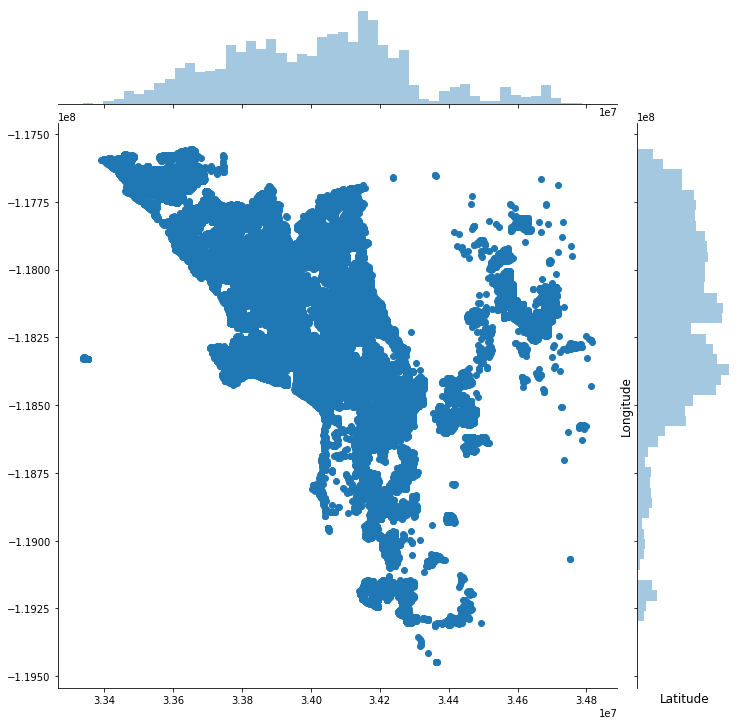

In [35]:
plt.figure(figsize=(12,12))
sns.jointplot(x=data.latitude.values, y=data.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show();

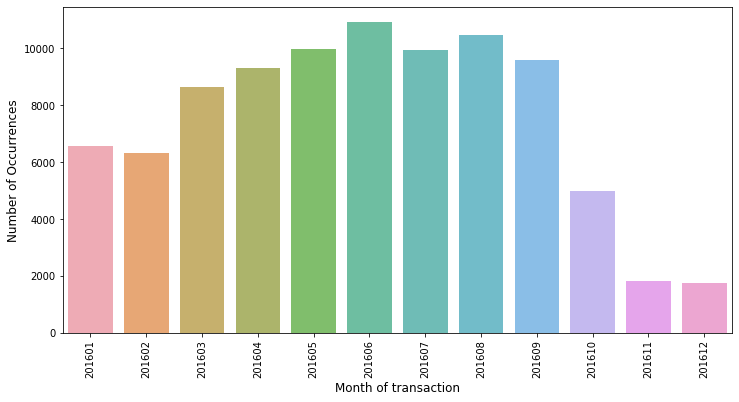

In [36]:
transactions = data['transactiondate'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(transactions.index, transactions.values, alpha=0.8)
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

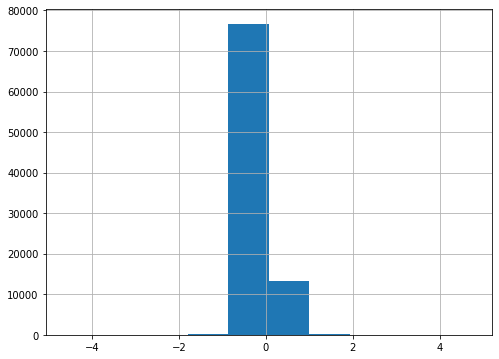

In [37]:
data['logerror'].hist(figsize=(8,6));

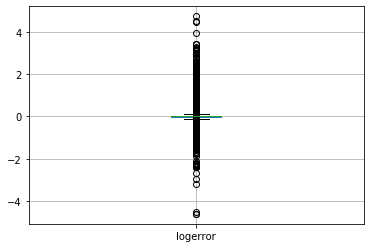

In [38]:
data['logerror'].plot(kind='box', grid=True);

In [39]:
scaler = RobustScaler()
train = scaler.fit_transform(data.select_dtypes(include='number'))